In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from keras.layers import Dense, MaxPool2D, Conv2D, BatchNormalization, Flatten, Dropout

In [2]:
#loading the data
(train, train_label), (test, test_label) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


# Data Exploration

In [3]:
print(train.shape)
print(train_label.shape)
print(test.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


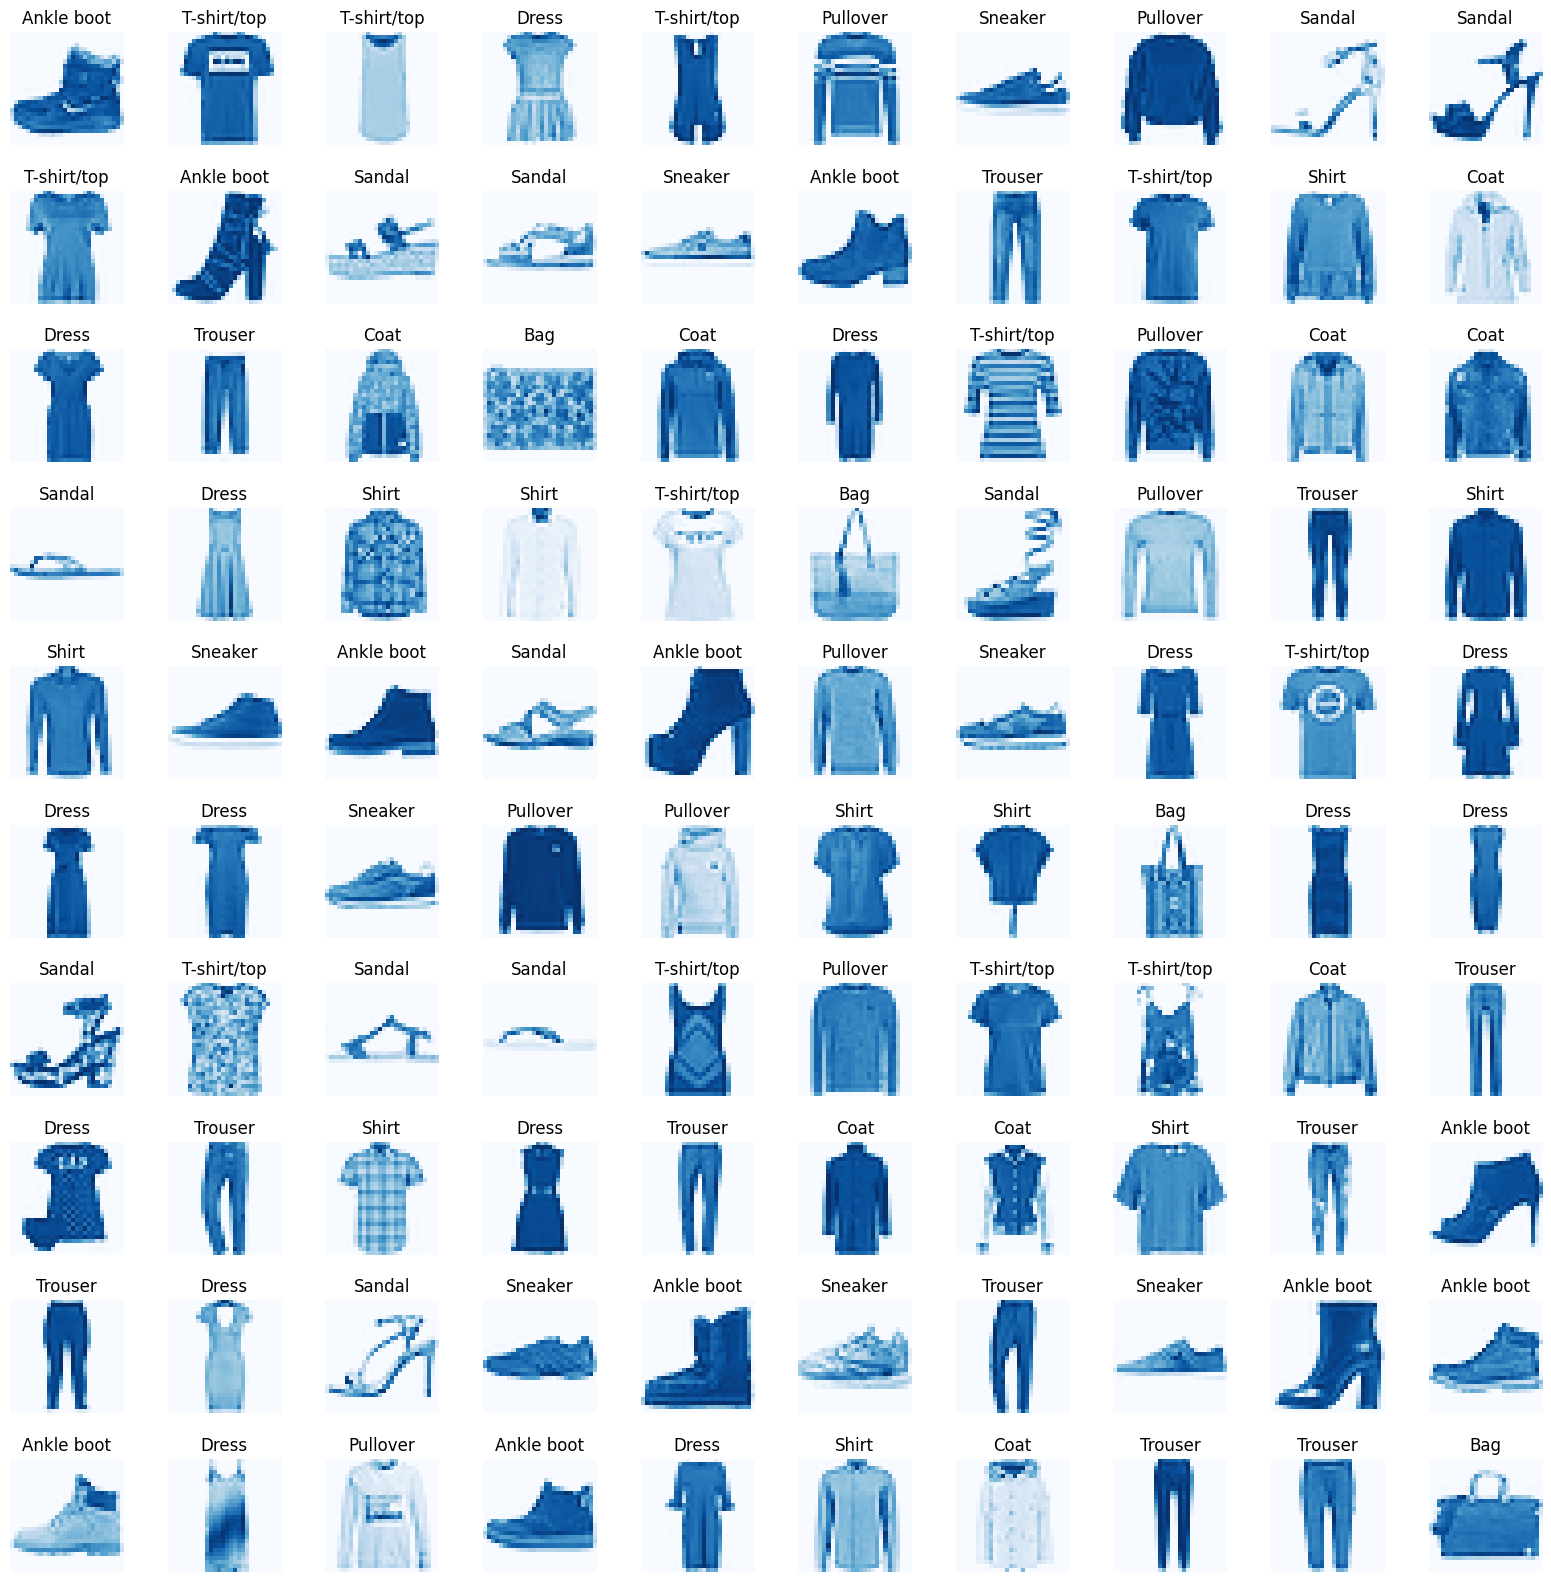

In [4]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(100):
    
    plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(train[i],cmap='Blues')
    plt.title(labels[int(train_label[i])],fontsize=12)
    plt.axis('off')

plt.show()

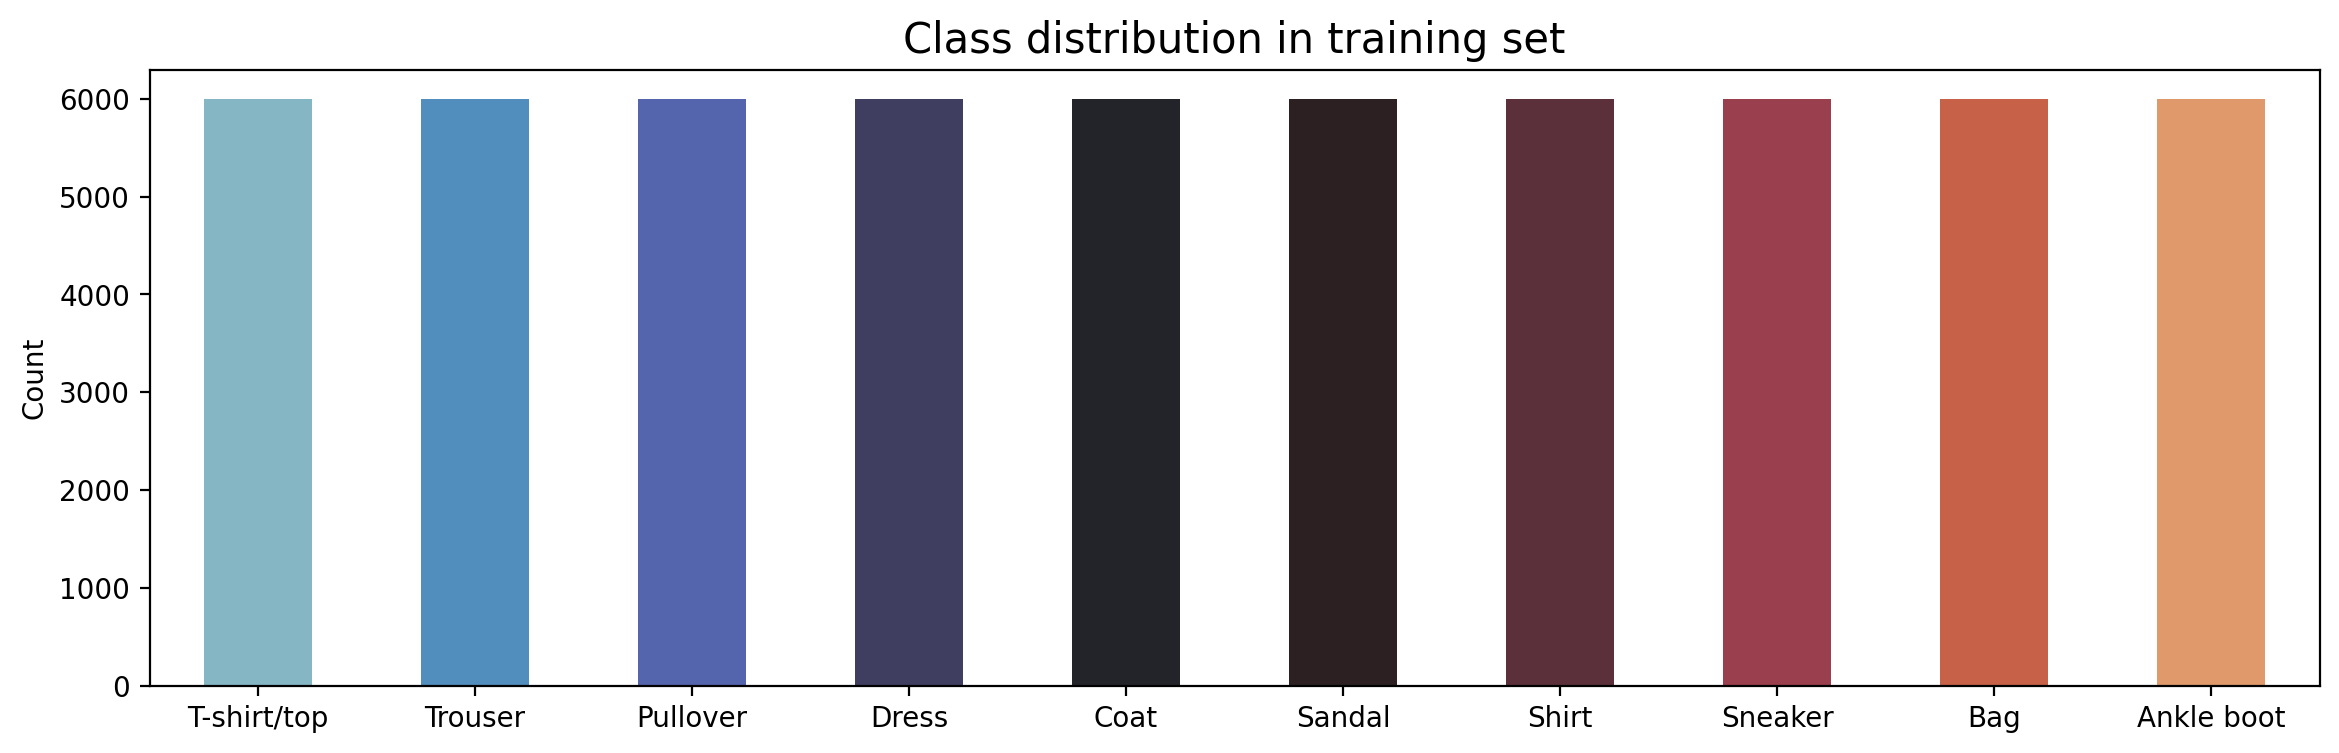

In [5]:
label,count = np.unique(train_label,return_counts=True)
uni = pd.DataFrame(data=count,index=labels,columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.5).set_title('Class distribution in training set',fontsize=15)
plt.show()

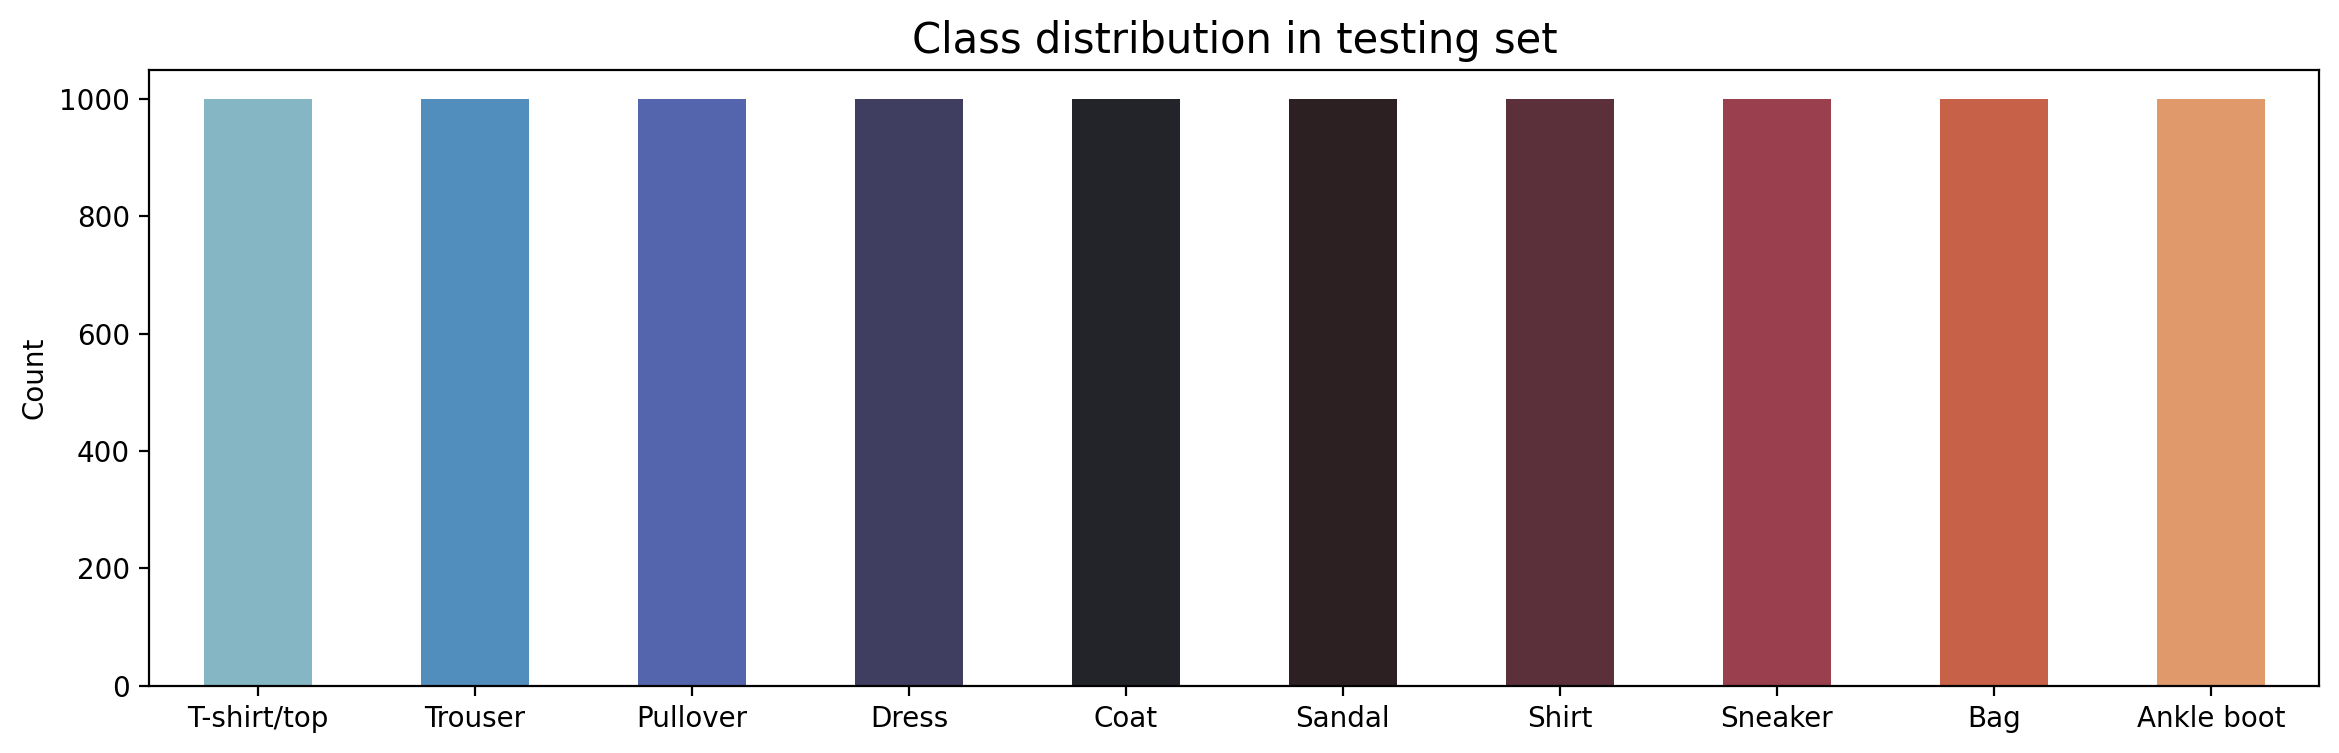

In [6]:
# count for Testing dataset
label,count = np.unique(test_label,return_counts=True)
uni = pd.DataFrame(data=count,index=labels,columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.5).set_title('Class distribution in testing set',fontsize=15)
plt.show()

# Data Preprocessing

In [7]:
# function to change the data type and normalize the data
# scaling the images 
def pre_process(data):
    return data/255

# function to chnage the labels into categorical data
def to_cat(data):
    return to_categorical(data,num_classes=10)

In [8]:
train = pre_process(train)
test = pre_process(test)

print('The shape of train_label before one hot encoding',train_label.shape)

train_label = to_cat(train_label)

print('The shape of y_train after one hot encoding',train_label.shape)

The shape of train_label before one hot encoding (60000,)
The shape of y_train after one hot encoding (60000, 10)


In [9]:
#splitting

X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.2, random_state=42)

print(X_train.shape[0])
print(X_test.shape[0])

48000
12000


In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Model 1

In [11]:
# 3 block vgg style model 
# Base of the model

model = models.Sequential()

# block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

# block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.3))

#block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#model.add(MaxPool2D())

# output layers
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10,activation='softmax'))


In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [13]:
# model compile
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# early_stoping callback
early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
fashion = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=10,
                    callbacks=[early_stoping],
                    verbose=0)

loss3,acc3 = model.evaluate(X_test,y_test,batch_size = 64, verbose = 0)

In [15]:
print('The accuracy of the Base Model is:',acc3*100)
print('The Loss of the Base Model is:',loss3)

The accuracy of the Base Model is: 93.15833449363708
The Loss of the Base Model is: 0.19296106696128845


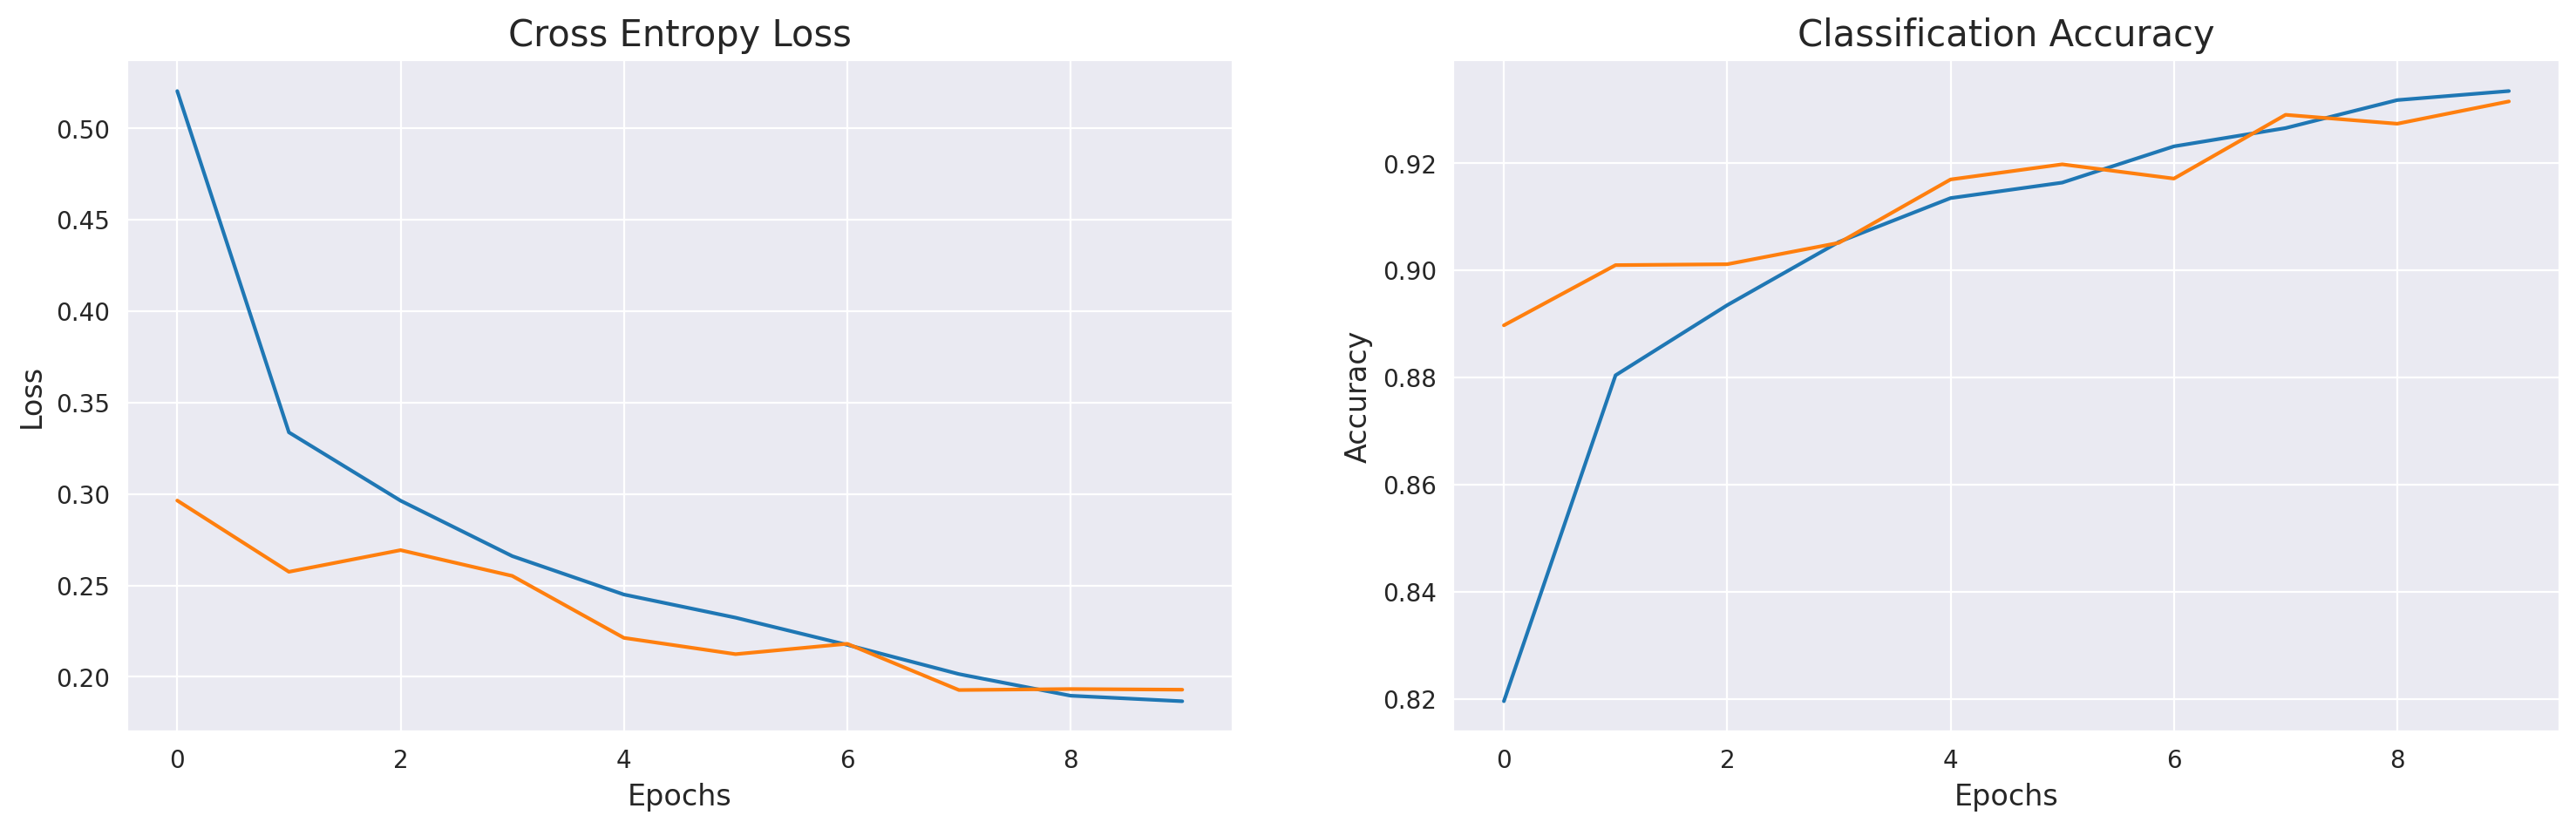

In [16]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(fashion.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

# Model 2

In [17]:
# Image Augmentation
datagen = ImageDataGenerator(#rotation_range=50,
                             horizontal_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1
                            )


train_gen = datagen.flow(X_train,y_train, batch_size=64)

fashion = model.fit(train_gen,
                    validation_data=(X_test,y_test),
                    epochs=10,
                   callbacks=[early_stoping])

Epoch 1/10
750/750 [==============================] - 132s 174ms/step - loss: 0.3786 - accuracy: 0.8645 - val_loss: 0.2217 - val_accuracy: 0.9187
Epoch 2/10
750/750 [==============================] - 129s 172ms/step - loss: 0.3036 - accuracy: 0.8904 - val_loss: 0.2069 - val_accuracy: 0.9268
Epoch 3/10
750/750 [==============================] - 130s 174ms/step - loss: 0.2861 - accuracy: 0.8950 - val_loss: 0.1984 - val_accuracy: 0.9287
Epoch 4/10
750/750 [==============================] - 128s 170ms/step - loss: 0.2757 - accuracy: 0.9004 - val_loss: 0.1984 - val_accuracy: 0.9250
Epoch 5/10
750/750 [==============================] - 129s 171ms/step - loss: 0.2650 - accuracy: 0.9033 - val_loss: 0.2086 - val_accuracy: 0.9213
Epoch 6/10
750/750 [==============================] - 130s 173ms/step - loss: 0.2613 - accuracy: 0.9061 - val_loss: 0.2034 - val_accuracy: 0.9256
Epoch 7/10
750/750 [==============================] - 129s 173ms/step - loss: 0.2523 - accuracy: 0.9085 - val_loss: 0.2179 -

In [18]:
# Evaluvate
loss3,acc3 = model.evaluate(X_test,y_test,batch_size = 64, verbose = 0)

print('The accuracy of the Final Model is:',acc3*100)
print('The Loss of the Final Model is:',loss3)

The accuracy of the Final Model is: 93.19166541099548
The Loss of the Final Model is: 0.18845361471176147


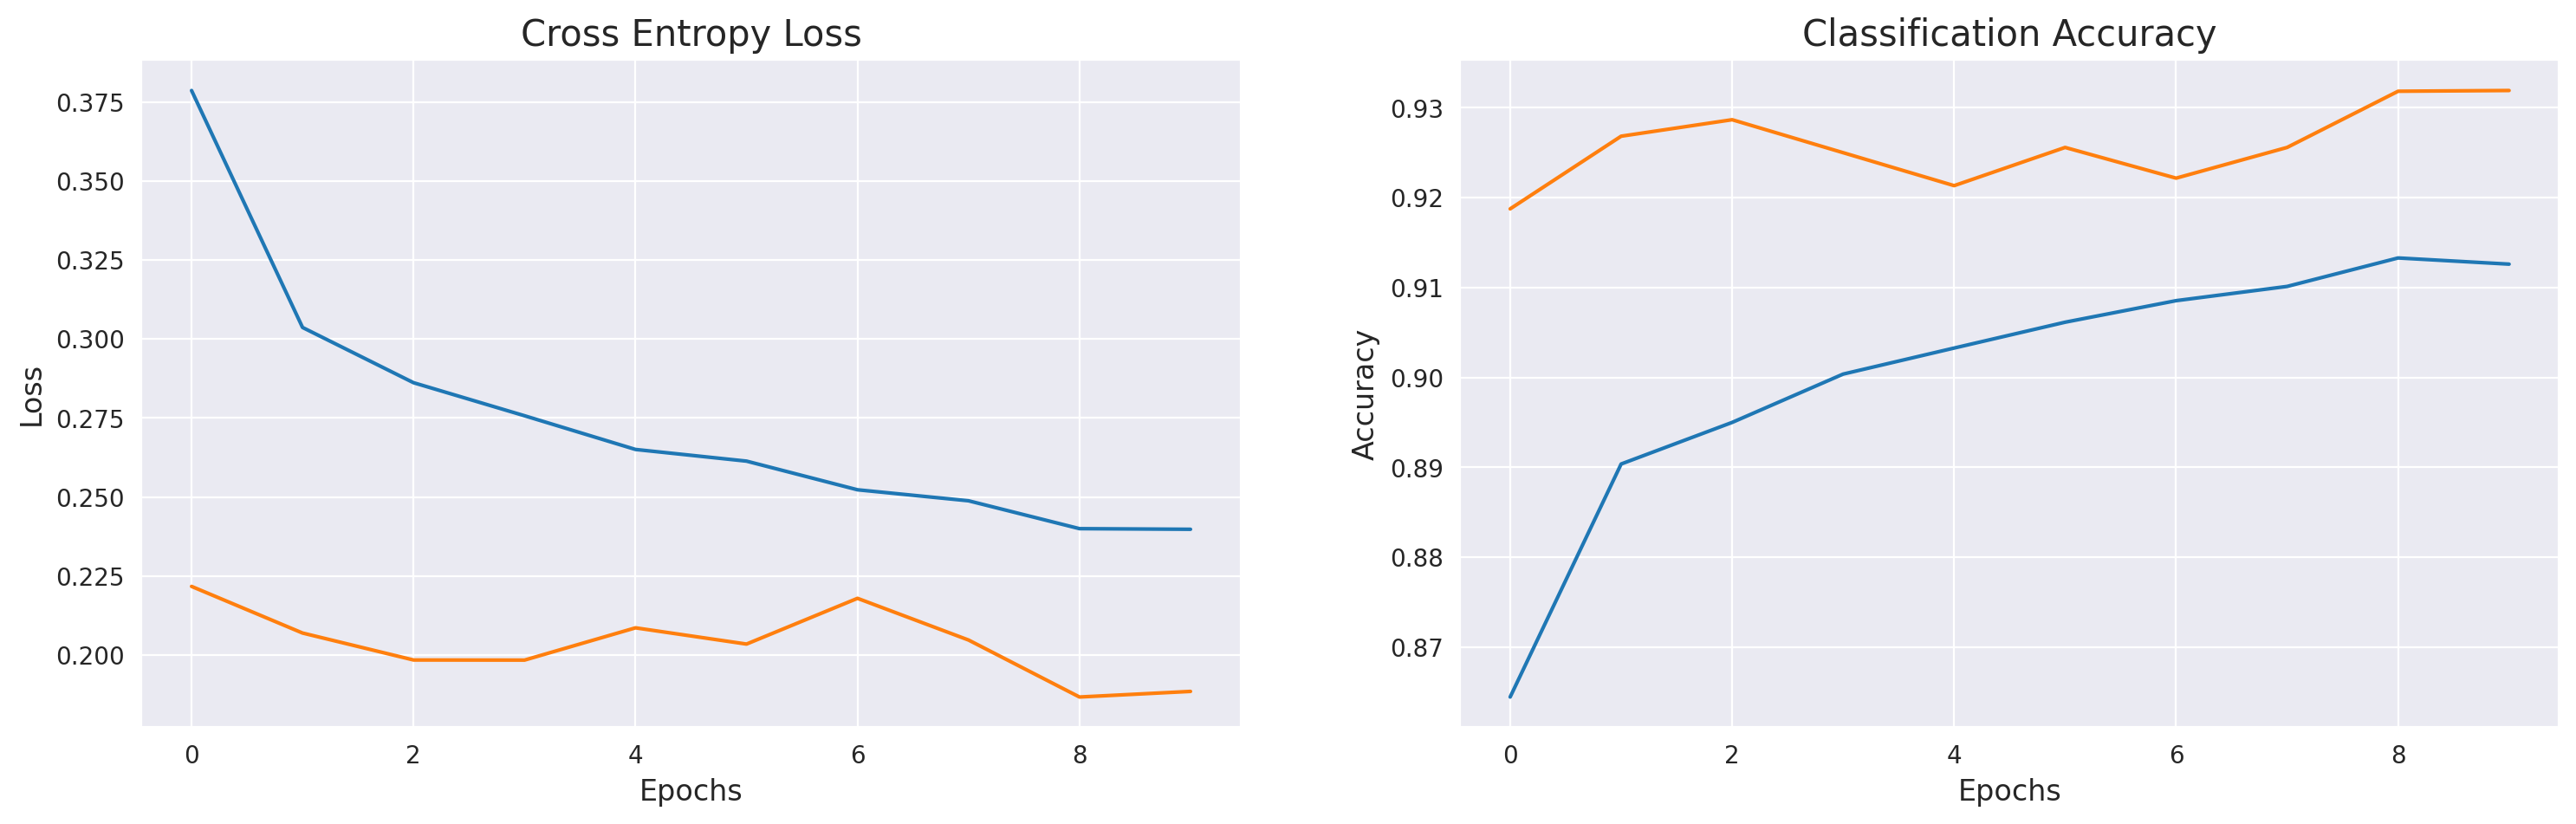

In [19]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(fashion.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [20]:
y_pred = model.predict(test)
y_pred = np.argmax(y_pred,axis=1)

313/313 [==============================] - 7s 23ms/step


In [21]:
print(classification_report(test_label,y_pred,target_names=labels))

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.86      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.92      0.89      0.90      1000
       Dress       0.91      0.94      0.92      1000
        Coat       0.85      0.92      0.89      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.80      0.79      0.79      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



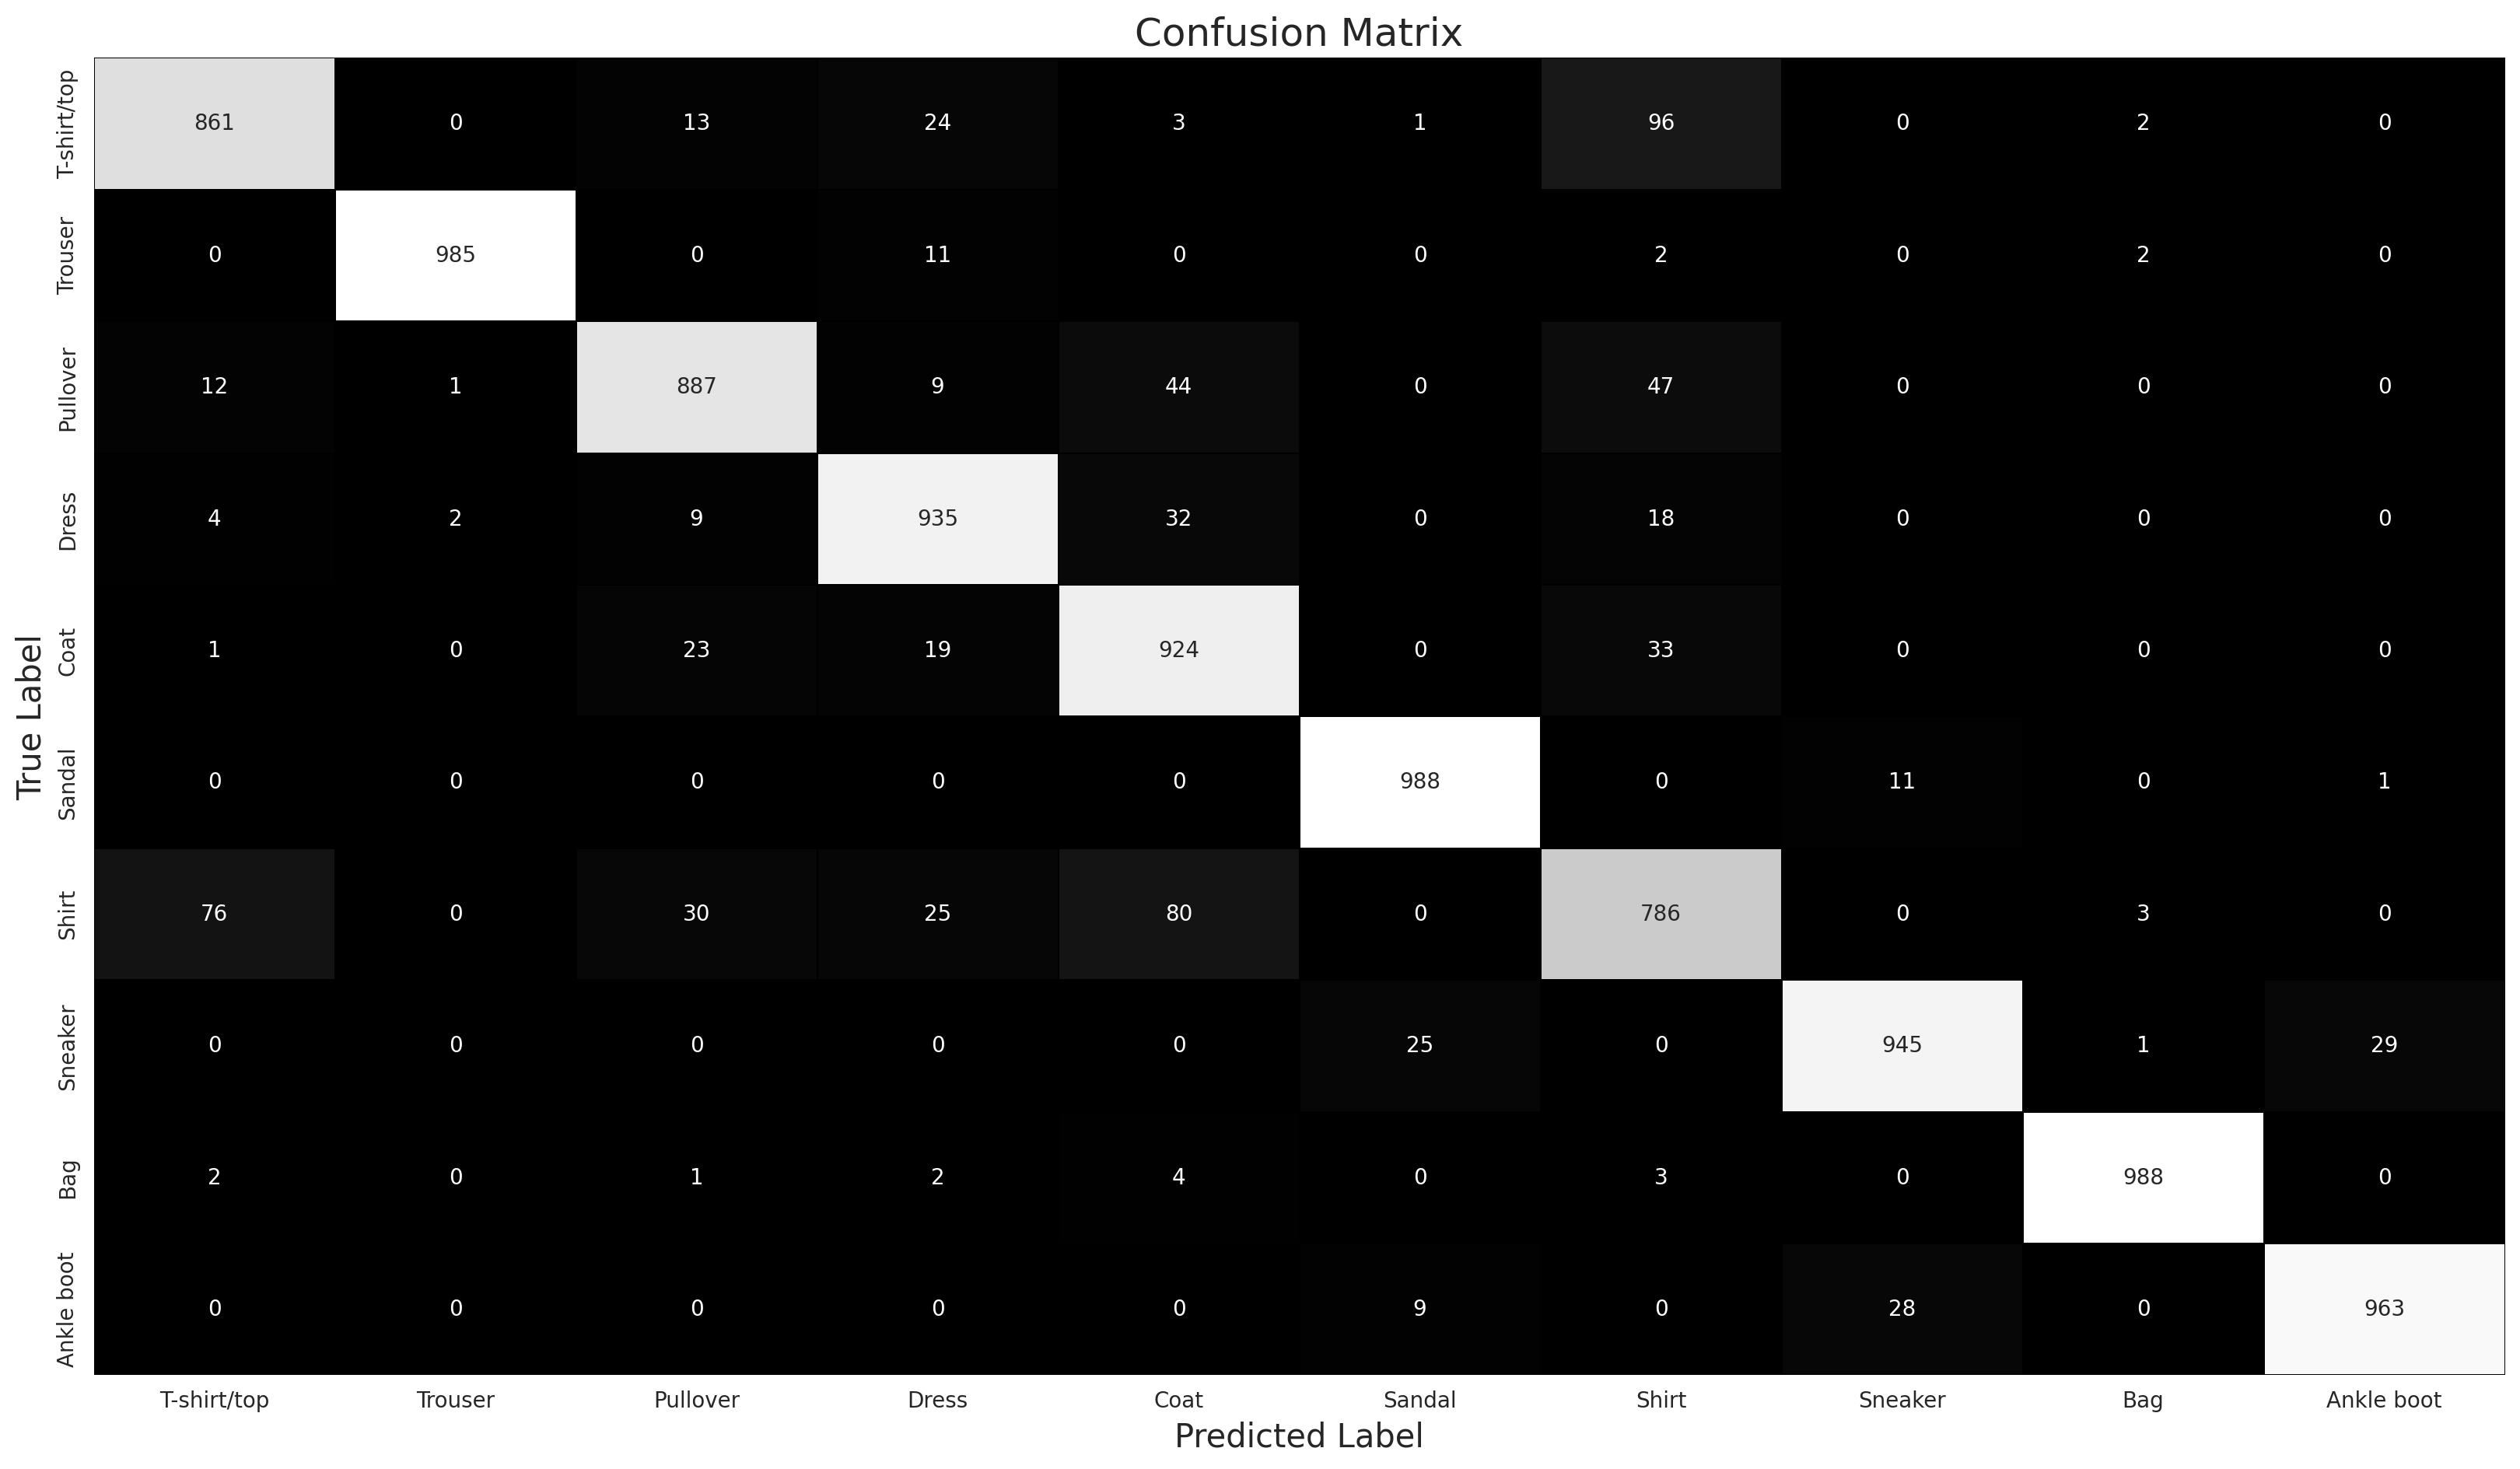

In [22]:
confusion_mtx = confusion_matrix(test_label,y_pred) 

f,ax = plt.subplots(figsize = (20,11),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False,xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Label",fontsize=15)
plt.ylabel("True Label",fontsize=15)
plt.title("Confusion Matrix",fontsize=18)
plt.show()

In [23]:
p = y_pred[:10000]
y = test_label[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9262
Incorrect predicted classes: 738
